In [2]:
# import sys
# sys.path.insert(0,'/home/kmatsuno/h5py/build/lib.linux-x86_64-2.7/')
import h5py
import glob
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np

import floatpy.readers.padeops_reader as por
import scripts.get_namelist as nml
from scripts.common import *
from scripts.decorr_lscale_y import get_L99

def get_data(directory,tID):
    
    # L99:
    fname = directory+'/shearlayer_utilde_%04d.dat'%tID
    utilde = np.fromfile(fname,count=-1,sep=' ')
    L99,itop,ibot = get_L99(yplot,utilde)

    # Ly lengthscales:
    fname = directory+'/lscale_vv_%04d.dat'%tID
    autocorr = np.fromfile(fname,sep=' ')
    autocorr = np.reshape(autocorr,[Ny,3])
    autocorr = autocorr[:,0]
    ly,i1,i2 = get_lscale(y,autocorr,thresh=0.25)
    
    # Lx,Lz lengthscales:
    fname = directory+'/autocorr_vv_%04d.h5'%tID
        hf =  h5py.File(fname,'r')
        autocorr2D = np.abs(np.fft.fftshift(hf['qx']))
        for k in range(Nz): autocorr2D /= np.amax(autocorr2D[:,k])
        autocorr = np.mean(autocorr2D,axis=-1)
        lx,i1,i2 = get_lscale(x,autocorr,thresh=0.2)
        
        autocorr2D = np.abs(np.fft.fftshift(hf['qz']))
        for k in range(Nx): autocorr2D /= np.amax(autocorr2D[k,:])
        autocorr = np.mean(autocorr2D,axis=0)
        lz,i1,i2 = get_lscale(z,autocorr,thresh=0.2)
    return L99,ly,lx,lz

In [3]:
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'

filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
yplot = np.linspace(-Ly/2,Ly/2,int(Ny))
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)
x = np.linspace(0,Lx,Nx)
z = np.linspace(0,Lz,Nz)
steps = sorted(reader.steps)
print("Steps: {}".format(steps))

dir_out = directory.split('/projects/ShockInducedMix/')[-1]
dir_out = '/home/kmatsuno/' + dir_out + '/'


Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
Steps: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


0.2


IOError: Unable to open file (unable to open file: name = '/home/kmatsuno/ShearLayerData/production/Mc02/rr1/1024x1448x512///autocorr_vv_0108.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

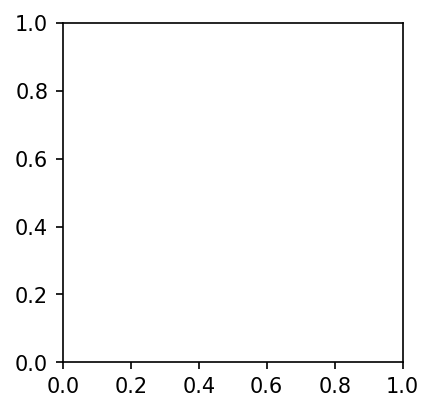

In [7]:
s = '1'
Mc_list = ['02','08','20']

fig = plt.figure(figsize=(3,3),dpi=150)
ax = plt.subplot(111, aspect='equal')

for i,Mc in enumerate(Mc_list):
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)
    x = np.linspace(0,Lx,Nx)
    z = np.linspace(0,Lz,Nz)

    flist = glob.glob(directory+"*utilde*.dat")
    flist.sort()
    dir_out = directory.split('/projects/ShockInducedMix/')[-1]
    dir_out = '/home/kmatsuno/' + dir_out + '/'

    if Mc=='02': ist=-6;ien=-1
    if Mc=='08': ist = 5;ien=None
    if Mc=='20': ist = 5;ien=-2
        
    print(inp.Mc)
    for j,fname in enumerate(flist[ist:ien]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        dtheta = get_dtheta(directory,time)

        L99,ly,lx,lz = get_data(dir_out,tID)
        if j==0: ells = Ellipse((0,0),lx/L99, ly/L99, 0,fill=False,edgecolor='C%i'%i,label='Mc')
        else: ells = Ellipse((0,0),lx/L99, ly/L99, 0,fill=False,edgecolor='C%i'%i)
        ells.set_alpha(0.4)
        ax.add_artist(ells,)
        #plt.plot(eta,fplot,color='C%i'%i,alpha=0.5,label='Mc = {}'.format(inp.Mc))
#         else: plt.plot(eta,fplot,color='C%i'%i,alpha=0.5)

plt.xlim([-0.5,0.5])
plt.ylim([-0.5,0.5])
# plt.xlabel(r'$\eta$')
# plt.ylabel(r"$\overline{\rho'%s'}$"%comp)
# plt.legend()
plt.grid(True)
